# Quantum Substring Comparison
#

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from math import log2, floor
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg
import matplotlib.pyplot as plt  

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Introduction

In recent years has gained ground the emerging field of quantum computing,giving the possibility to implement algorithms with superior asymptotic performance to those achievable using classical computers.   
The aim of the project is to provide an implementation of a quantum algorithm [1] :https://arxiv.org/abs/2308.11758, which solve a classical problem related to text processing, and compare the performance with a classical implemention of the same algorithm.
Given two input strings, x and y, both of length n, and a value d ⩽ n, we want to verify the following conditions:  
the existence of a common prefix of length d, the presence of a common substring of length d beginning at position j  and, the presence  of any common substring of length d beginning in both strings at the same position.
Formally, given tow input strings x and y,both of length n, whose character are drown from an alphabet S, and a parameter d,with 0 < d ⩽ n, we want to solve the following problems:
- the Fixed Prefix Matching (FPM) problem, which tests for the existence of  a common prefix of length d between x and y, checks whether:  
   <pre>                                  x[0,1...d-1]= y[0,1...d-1]</pre>                                        
- the Fixed Factor Matching (FFM) problem, which test, for a given parameter j, with 0 ⩽ j < n−d , the existence of a common substring(of length d) between x and y, starting at index j .
   <pre>                                  x[j,j+1...j+d-1]= y[j,j+1...j+d-1]            </pre>
- the Shared Fixed Substring Checking (SFSC) problem, which tests for  the existence of a common substring between x and y, of length d,     starting at index j in both strings. It tests whether:
   <pre>                        ∃ j : 0 ⩽ j < n−d and x[j,j+1...j + d − 1] = y[j,j+1...j + d − 1]     <pre>                                             

## A gentle introduction to quantum Computing

Qbit is the basic unit of quantum computation and can be understood as the quantum equivalent of the traditional bit used in
classical computers.
It is a two-state quantum mechanical system, one of the simplest quantum systems displaying the peculiarity of quantum mechanics, 
examples include the spin of the electron or the polarization of a single photon.  
In quantum mechanics a general quantum state can be represented by a vector defined on Hilbert space  $\mathcal{H}$, in particular a qbit, that is a very simple quantum mechanical system, can be represented as linear combination of two basis states |0$\rangle$ and |1$\rangle$:
$$ |\psi\rangle = \alpha|0\rangle + \beta|1\rangle\ \alpha,\beta \in \mathbb{C}\ $$
where |$\alpha$|$^2$ and |$\beta$|$^2$ represent the probability of outcome  |0$\rangle$ and  |1$\rangle$ respectively. Because the absolute squares of the amplitudes equate to probabilities, it follows that $\alpha$ and $\beta$ must be constrained, according to the second axiom of probability theory, by the equation:
$$ |\alpha|^2 + |\beta|^2=1$$
This expression represent quantum superposition, a key concept that distinguishes quantum mechanical system from their classical counterpart.  
  
Multiple qbits taken together are referred to as a quantum registers.A quantum register |$\psi\rangle$=|q1,..qn$\rangle$ is the tensor product of constituent qbits:
$$ |\psi\rangle= \otimes_{i=1}^n q_i $$ 

### Quantum Operators

A qbit can be represented in the Bloch sphere.However, a qbit has four parameter but a sphere allows 
only three dimensional representation, so Bloch manipulated the definition to obtain this equation:
$$ \ket{\psi} = \cos \frac{\theta}{2} \ket{0} + e^{i \phi} \sin \frac{\theta}{2} \ket{1} $$

A quantum operation maps a point u on the unit sphere to some other point q on the unit sphere, 
so an operation can be represented by a matrix.
Moreover, we restrict these matrices to be linear and invertible, such matricies are called unitary.
- linearity
$$ A(\alpha \ket{\psi_1} + \beta \ket{\psi_2}) = \alpha A(\ket{\psi_1}) + \beta A(\ket{\psi_2})\
\forall \alpha, \beta \in \mathbb{C},\ \forall \ket{\psi_1}, \ket{\psi_2} \in \mathcal{H} $$
- invertibility
$$ U^\dagger U = I\ \ \
 UU^\dagger = I $$
                  where $U^\dagger$ is the complex conjugate of $U$ and $I$ is the identity matrix.   
The following are the elementary quantum operators we will use :
- NOT gate, formally it maps |0$\rangle$ to |1$\rangle$ and vice versa
$$
NOT = \begin{bmatrix} 0 & 1\\ 1 & 0\end{bmatrix}
$$ 

- CNOT gate, formally it maps |q$_0$,q$_1$ $\rangle$ to |q$_0$,q$_0$ $\oplus$q$_1$ $\rangle$
$$
CNOT = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix}
$$

- SWAP gate, formally it maps |q$_0$,q$_1$ $\rangle$ to |q$_1$,q$_0$ $\rangle$, it could be obtained applying three times CNOT
$$
SWAP = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

- the FREDKIN gate, that consist in swap gate controlled by a single qbit
$$
FREDKIN = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix}
$$
- Toffoli gate, it  formally maps |q$_0$,q$_1$, q$_2$ $\rangle$ to |q$_0$,q$_1$, q$_0$ $\oplus$q$_1$ $\oplus$q$_2$ $\rangle$
$$
CX3 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0  \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\end{bmatrix}
$$

- Multiple CNOT, formally it maps |q$_0$,q$_1$,q$_2$...q$_n$ $\rangle$ to |q$_0$,q$_1$,q$_2$... ,q$_0$ $\oplus$ q$_1$ $\oplus$ q$_2$ $\oplus$ q$_n$ $\rangle$

### Quantum Boolean Oracles

Given a function f: {0}$^n$ -> {1}$^n$,any quantum operator that maps a register containing the value of a given input x ∈ {0, 1}$^n$ into a register whose value depends on f (x) is called a quantum  boolean oracle.Formally,
$$
U_f|x,0\rangle=|x,f(x)\rangle
$$

### Quantum Complexity

 A quantum algorithm can be shaped using the quantum circuit computational model.It represent quantum algorithms as sequences
of quantum gates that manipulate qubits.This approach delves into the specifics
of how quantum operations are executed and provides a structured methodology
for designing and optimizing quantum algorithms.We assume the
circuit as being divided into a sequence of discrete time-steps, where the appli-
cation of a single gate requires a single time-step. The depth of the circuit is the
total number of required time-steps and it is the time complexity measure

## Algorithm 

In this section we will illustrate the different part of the algortihm. Theoretical detail are interspersed with python code implemenation(for creating quantum circuits we will use qiskit library).  
Below you can find some utility routine that we will use later. 

In [2]:
#print the quantum circuit passed to the function 
def draw_circuit(circuit):
    circuit.draw(output='mpl',filename="image.jpg")
    fig, ax = plt.subplots()
    im = mpimg.imread('image.jpg')
    ax.axis('off')
    ax.imshow(im)

In [15]:
# run Quantum Circuit using Aer Simulator 
def run(qc, shots):
    simulator = AerSimulator(method='matrix_product_state')
    compiledCircuit = transpile(qc, simulator)
    job = simulator.run(compiledCircuit, shots = shots).result()
    result = job.get_counts(compiledCircuit)
    return result

In [16]:
#print results of the measurement
def counts(results):
    print("COUNT:")
    for i in results :
        print(" -- " + str(i)[::-1] + " : " + str(results[i]))

### Matcing Substring Vectors

Given i$\ge$0, we define the matching substring vectors $\lambda^{i}$,  for 0$\le$i$\le$log(d), as a bit vector of size n - 2$^i$ + 1, such that for  0$\le$j$\le$n-2$^i$, we have :  
$$
\lambda{^i}[j] =\begin{cases}
  1 \ \ if \ \ x[j..j+ 2^{i}-1] = y[j..j+2^{i}-1]\\
  0 \ \         otherwise 
\end{cases}$$
Such vectors can be recursively computed by means of the following relation:
$$
\lambda{^i}[j] =\begin{cases}
  1 \ \  \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \  \ \ \ \ \ \ \ \  \ \ \ if \ \ i=0 \ \ AND \ \ x[j]=y[j]\\
  0 \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ \ i=0 \ \ AND  \ \ x[j]\ne y[j] \\
  \lambda^{i-1}[j] \ \ AND  \ \ \lambda^{i-1}[j + 2^{i-1}] \ if \ i>0
\end{cases}$$

Therefore, we can compute  recursively $\lambda{^i}$ from $\lambda^{i-1}$, while $\lambda{^0}$, that is the base case, can be computed by comparing characters of vectors x and y.  
Below you can find a qiskit circuit that implement this recursion.

#### Gate M implementation

gate M performs, $\forall$ x, y $\in${0,1}$^n$ the following mapping:  
$$
M|x>|y>|0^{n}>=|x>|y>|\lambda^0>
$$
Based on the simple following relation:
$$
\lambda^0[j]=(x_j \ \ AND \ \ y_j) \ \ \oplus \ \ (-x_j \ \ AND \ \ -y_j)
$$
Therefore, gate M implement the base case of the recursion

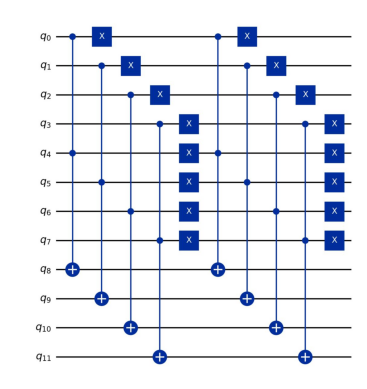

In [23]:
def M(n, draw):
    qc = QuantumCircuit(3*n)

    for i in range(n):
        qc.ccx(i, i + n, i + 2*n)
        qc.x(i)
        qc.x(i + n)
        qc.ccx(i, i+ n, i+ 2*n)
        qc.x(i)
        qc.x(i + n)
        
    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="M")
    return qc 

circuit = M(4, True)

#### Gate EXT implementation

|$\lambda^{i}$> is computed from |$\lambda^{i-1}$> using EXT$_i$ operator, formally it operates the following mapping:  
$$
\forall i : 0\le i \le log(d) \ \ \ EXT_i|\lambda^{i-1}>|0^n>=|\lambda^{i-1}>|\lambda^{i}>
$$
Gate EXT$_i$ implement the recursive step

Instruction(name='circuit-250', num_qubits=12, num_clbits=0, params=[])

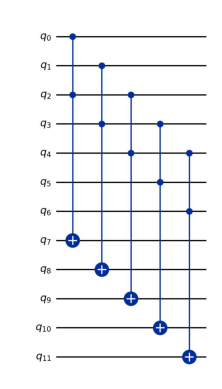

In [41]:
def EXT(n, i, draw):

    qc = QuantumCircuit(2*n - 2**i)

    for j in range(n -2**i):
        qc.ccx(j, j + 2**i, j + n)
        
    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="EXT" + str(i))

    return qc 

# calculating lamda^2 from lamda^1 where n = 8 
EXT(7, 1, True)

### Power based decomposition of a string

Let $\bar{d}$= $\bar{d}$[0,1...$\lfloor$ log(d) $\rfloor$] being the vector storing the bit representation of d in its reversed order, so:
$$
d = \sum_{i=0}^{\lfloor log(d) \rfloor} \bar{d}[i] 2^i
$$
We use the expression $\bar{d}$[0:m] to denote the partial sum of such binary representation,formally we have:
$$
d[0:m] = \sum_{i=0}^{m} \bar{d}[i] 2^i
$$
We set by default $\bar{d}$[0:i]=0 $\forall$ i<0  
In addition let S be the positions of d where d[i]=1, in increasing order, so that d =$\sum_{i\in{S}}2^i$. Now consider the following decomposition of a string w:  
$$
w=\uplus_{i\in{S}}w[\bar{d}[0:i-1]..\bar{d}[0:i]-1]
$$
Such a decomposition is called power-pased-decomposition

### Reversal Operator

Operator REV inverts position of its qbit, formally:
$$
REV|q>\ = |\bar q>
$$

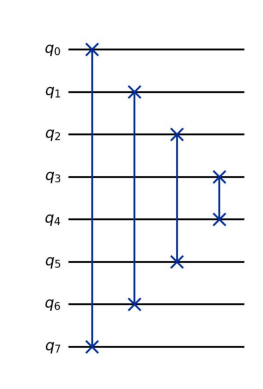

In [5]:
def REV(dLen, draw):
    qc = QuantumCircuit(dLen)

    for i in range(0, floor(dLen/2)):
        qc.swap(i, dLen - i - 1)

    if(draw): draw_circuit(qc)
    qc = qc.to_gate(label="REV")
    return qc 

circuit = REV(8, True)

### Vectors of results

Before getting in to the details of how the vector of results D is build, we want to mark this interesting property, 
it basically says that two factors of x and y, starting at the same position j matching if and only if, the strings of their power based decomposition matching each other, formally :   
  
Let x and y be any two strings of length n over some alphabet $\sum$and let d be a constant, with 0 < d ⩽ n. For a given j such that 0 ⩽ j < n − d, we have:  
$$
x[j .. j + d − 1] = y[j .. j + d − 1] \longleftrightarrow \land_{i \in S}\lambda^{i}[j+\bar{d}[0:i-1]]=1
$$
Based on this property the algorithm mantain the set of vector $D^i$,for -1 ⩽ i ⩽ $\lfloor$log(d)$\rfloor$,where :  
$$
D^i[j+\bar{d}[0:i]]=1 \longleftrightarrow  x[j..j + \bar{d}[0,i] − 1] = y[j..j + \bar{d}[0,i] − 1]
$$
The idea is to check, at i-th step, if x and y have a common factor starting in position j, if so, shift $D^i$ of $2^i$ positions,formally:
$$
D^i = (D^{i−1} ∧ λ^{i} ) ≫ 2^i
$$

In the end:
$$
\forall j⩽ n -d \ \ \  D^{\lfloor log(d) \rfloor}[(j + d)mod(n)]=1 \longleftrightarrow x[j .. j + d − 1] = y[j .. j + d − 1]
$$
The correctness of this procedure is justified by the first property exhibited in this paragraph.  
Please note that since we assume that an empty substring starting at position j is always shared between the two strings, for any value 0 ⩽ j < n,the vector can be initialized to $D^1$ = $1^{n+1}$ .

### Controlled Rotation Gate

Operator $ROT_s$ applied a rightward rotation of s position to a register r, so that element at position i we will found at position (i+s)mod(n), in addition the operator assumes that |r|=$2^p$ for some p $\ge$0.Formally the operator $ROT_s$ apply this permutation:
$$
ROT_k|q_0,q_1,q_2,...q_{n-1}>=|q_{n-k},q_{n-k+1},q_{n-k+2},...q_{n-k-1}>
$$

However, we are interested in a controlled version of $ROT_s$, where the rotation is applied if and only if a control bit, said c, is set to 1. Formally the operator $CROT_k$ applied this mapping:
$$
CROT_k|c,q_0,q_1,q_2,...q_{n-1}> = \begin{cases}
|c,q_{n-k},q_{n-k+1},q_{n-k+2},...q_{n-k-1}>  \ \ \ \ \ \ \ if \ \ |c> = |1> \\
|c,q_0,q_1,q_2,...q_{n-1}>  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ if \ \ |c> = |0> 
\end{cases}
$$

Note that due to modular rotation, the procedure could find common circular factor, but we can solve this issue assuming that the two strings must end with two distinct special character  # and %, such that #,% $\notin \sum$.Moreover, if the length of the string is not a power of two, we can concatenate to that its final special character any arbritary numbers of times.

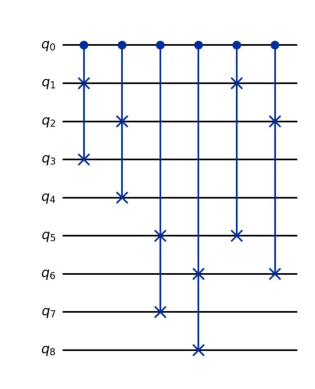

In [4]:
def CROT(n, k, draw):

    qc = QuantumCircuit(n +1)

    for i in range(1, int(log2(n) - int(log2(k))+ 1)):
        for j in range(0, int(n/(k*2**i))):
            for x in range(k*j*2**i, k*j*2**i + k):
                qc.cswap(0, x + 1, 1 + x + k*2**(i-1))

    if(draw):draw_circuit(qc)
    qc = qc.to_gate(label="ROT" + str(k))
    return qc 

circuit = CROT(8,2, True) # a controlled 2-rightrotation a register of size n=8  

### The controlled bitwise conjunction operator

Finally, we present BCJ, it performs controlled bit-to-bit logical and between two
registers, |a> and |b>, of n qubits, depositing the result within a third register |qi>. Formally, 
$$
\land |c>|a>|b>|0^{n}>=|c>|a>|b>\otimes_{i=0}^{n-1}|c \land a \land b>
$$

### Pseudocode of the algorithm

FSM(d, x, y, D$^{-1}$ ):
1. λ0 = M(x, y)  
2. if( $\bar{d}$[0] = 1) then D$^{0}$ = (D$^{-1}$ ∧ λ$^{0}$ ) ≫ 2$^{0}$  
3. for i = 1 to log(d) do  
4.  λ$^{i}$ = EXT$_{i}$(λ$_{i-1}$)
5.  if ($\bar{d}$[i] = 1) then D$^i$ = (D$^{i-1}$ ∧ λ$^{i}$ ) ≫ 2$^{i}$  
6.  else D$^{i}$ = D$^{i-1}$
7.  end for 
8. r=V$_{j=d}^{n}$D$^{log(d)}$[j$\cdot$ mod(n)]  
9. return r